# DC2 Image Analysis, 511 keV, Image Deconvolution using CDS in the Galactic coordinate system

updated on 2024-07-29 (the commit 14fc4c42f8b33749bd2053603643ca693dbc3954)

This notebook focuses on the image deconvolution with the Compton data space (CDS) in the Galactic coordinate system.
An example of the image analysis will be presented using the 511keV thin disk 3-month simulation data created for DC2.

In DC2, we have two options on the coordinate system to describe the Compton scattering direction ($\chi\psi$) in the image deconvolution. Please also check the notes written in [511keV-DC2-ScAtt-DataReduction.ipynb](https://github.com/cositools/cosipy/blob/main/docs/tutorials/image_deconvolution/511keV/ScAttBinning/511keV-DC2-ScAtt-DataReduction.ipynb)

In [1]:
import logging
import sys
logger = logging.getLogger('cosipy')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler(sys.stdout))

In [3]:
from histpy import Histogram, HealpixAxis, Axis, Axes
from mhealpy import HealpixMap
from astropy.coordinates import SkyCoord, cartesian_to_spherical, Galactic

from cosipy.response import FullDetectorResponse
from cosipy.spacecraftfile import SpacecraftFile
from cosipy.ts_map.TSMap import TSMap
from cosipy.data_io import UnBinnedData, BinnedData
from cosipy.image_deconvolution import SpacecraftAttitudeExposureTable, CoordsysConversionMatrix, DataIF_COSI_DC2, ImageDeconvolution
from cosipy.util import fetch_wasabi_file

# cosipy uses astropy units
import astropy.units as u
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from scoords import Attitude, SpacecraftFrame

#3ML is needed for spectral modeling
from threeML import *
from astromodels import Band

#Other standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec 

import healpy as hp
from tqdm.autonotebook import tqdm

%matplotlib inline

# 0. Files needed for this notebook

From wasabi
- cosi-pipeline-public/COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz (please gunzip it)
    - a pre-computed 511 keV line response file converted into the Galactic coordinate system
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_unbinned_data.fits.gz
- cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz
    - In this notebook, only the albedo gamma-ray background is considered for a tutorial.
    - If you want to consider all of the background components, please replace it with cosi-pipeline-public/COSI-SMEX/DC2/Data/Backgrounds/total_bg_3months_unbinned_data.fits.gz
    - Note that total_bg_3months_unbinned_data.fits.gz is 14.15 GB.

From docs/tutorials/image_deconvolution/511keV/GalacticCDS
- inputs_511keV_DC2.yaml
- imagedeconvolution_parfile_gal_511keV.yml

You can download the data and detector response from wasabi. You can skip this cell if you already have downloaded the files.

In [ ]:
# Response file:
# wasabi path: COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz
# File size: 3.82 GB
fetch_wasabi_file('COSI-SMEX/DC2/Responses/PointSourceReponse/psr_gal_511_DC2.h5.gz')
os.system('gunzip psr_gal_511_DC2.h5.gz')

In [ ]:
# Source file (511 keV thin disk model):
# wasabi path: COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_unbinned_data.fits.gz
# File size: 202.45 MB
fetch_wasabi_file('COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_unbinned_data.fits.gz')

In [ ]:
# Background file (albedo gamma):
# wasabi path: COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz
# File size: 2.69 GB
fetch_wasabi_file('COSI-SMEX/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz')

# 1. Create binned event/background files in the Galactic coordinate system

<span style="color:red"> please modify "path_data" corresponding to your environment.</span>

In [4]:
path_data = "path/to/data/"

**Source**

In [4]:
%%time

signal_filepath = path_data + "511_thin_disk_3months_unbinned_data.fits.gz"

binned_signal = BinnedData(input_yaml = "inputs_511keV_DC2.yaml")

binned_signal.get_binned_data(unbinned_data = signal_filepath, psichi_binning="galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 7.75 s, sys: 255 ms, total: 8 s
Wall time: 8.06 s


**Background**

In [5]:
%%time

bkg_filepath = path_data + "albedo_photons_3months_unbinned_data.fits.gz"

binned_bkg = BinnedData(input_yaml = "inputs_511keV_DC2.yaml")

binned_bkg.get_binned_data(unbinned_data = bkg_filepath, psichi_binning="galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None
CPU times: user 1min 51s, sys: 3.96 s, total: 1min 55s
Wall time: 1min 55s


Convert the data into sparse matrices & add the signal to the background

In [7]:
signal = binned_signal.binned_data.to_dense()
bkg = binned_bkg.binned_data.to_dense()
event = signal + bkg

Save the binned histograms

In [8]:
signal.write("511keV_dc2_galactic_signal.hdf5", overwrite = True)
bkg.write("511keV_dc2_galactic_bkg.hdf5", overwrite = True)
event.write("511keV_dc2_galactic_event.hdf5", overwrite = True)

Load the saved files

In [5]:
signal = Histogram.open("511keV_dc2_galactic_signal.hdf5")
bkg = Histogram.open("511keV_dc2_galactic_bkg.hdf5")
event = Histogram.open("511keV_dc2_galactic_event.hdf5")

In DC2, the number of time bins should be 1 when you perform the image deconvolution using the galactic CDS.
It is because the pre-computed response files in the galactic coordinate have no time axis, and all of the events are assumed to be projected into a single galactic CDS.
In the future, we plan to introduce more flexible binning.

In [6]:
bkg.axes['Time'].edges

<Quantity [1.83548730e+09, 1.84346726e+09] s>

# 2. Load the response matrix

In [7]:
%%time

response_path = path_data + "psr_gal_511_DC2.h5"

image_response = Histogram.open(response_path)

CPU times: user 3.3 s, sys: 23.2 s, total: 26.5 s
Wall time: 38 s


In [8]:
image_response.axes.labels

array(['NuLambda', 'Ei', 'Em', 'Phi', 'PsiChi'], dtype='<U8')

In [9]:
image_response.contents.shape

(3072, 1, 1, 60, 3072)

# 3. Imaging deconvolution

## Brief overview of the image deconvolution

Basically, we have to maximize the following likelihood function

$$
\log L = \sum_i X_i \log \epsilon_i - \sum_i \epsilon_i
$$

$X_i$: detected counts at $i$-th bin ( $i$ : index of the Compton Data Space)

$\epsilon_i = \sum_j R_{ij} \lambda_j + b_i$ : expected counts ( $j$ : index of the model space)

$\lambda_j$ : the model map (basically gamma-ray flux at $j$-th pixel)

$b_i$ : the background at $i$-th bin

$R_{ij}$ : the response matrix

Since we have to optimize the flux in each pixel, and the number of parameters is large, we adopt an iterative approach to find a solution of the above equation. The simplest one is the ML-EM (Maximum Likelihood Expectation Maximization) algorithm. It is also known as the Richardson-Lucy algorithm.

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \delta \lambda_{j}^{k}
$$
$$
\delta \lambda_{j}^{k} = \frac{\lambda_{j}^{k}}{\sum_{i} R_{ij}} \sum_{i} \left(\frac{ X_{i} }{\epsilon_{i}} - 1 \right) R_{ij} 
$$

We refer to $\delta \lambda_{j}^{k}$ as the delta map.

As for now, the two improved algorithms are implemented in COSIpy.

- Accelerated ML-EM algorithm (Knoedlseder+99)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \delta \lambda_{j}^{k}
$$
$$
\alpha^{k} < \mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k})
$$

Practically, in order not to accelerate the algorithm excessively, we set the maximum value of $\alpha$ ($\alpha_{\mathrm{max}}$). Then, $\alpha$ is calculated as:

$$
\alpha^{k} = \mathrm{min}(\mathrm{max}(- \lambda_{j}^{k} / \delta \lambda_{j}^{k}), \alpha_{\mathrm{max}})
$$

- Noise damping using gaussian smoothing (Knoedlseder+05, Siegert+20)

$$
\lambda_{j}^{k+1} = \lambda_{j}^{k} + \alpha^{k} \left[ w_j \delta \lambda_{j}^{k} \right]_{\mathrm{gauss}}
$$
$$
w_j = \left(\sum_{i} R_{ij}\right)^\beta
$$

$\left[ ... \right]_{\mathrm{gauss}}$ means that the differential image is smoothed by a gaussian filter.

## 3-1. Prepare DataInterface containing all necessary datasets

In [10]:
%%time

data_interface = DataIF_COSI_DC2.load(name = "511keV",
                                      event_binned_data = event.project(['Em', 'Phi', 'PsiChi']),
                                      dict_bkg_binned_data = {"albedo": bkg.project(['Em', 'Phi', 'PsiChi'])},
                                      rsp = image_response,
                                      coordsys_conv_matrix=None,
                                      is_miniDC2_format=False)

Note that _modify_axes() in DataLoader was implemented for a temporary use. It will be removed in the future.
... checking the axis Em of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis Phi of the event and background files...
    --> pass (edges)
    --> pass (unit)
... checking the axis PsiChi of the event and background files...
    --> pass (edges)
    --> pass (unit)
...checking the axis Em of the event and response files...
    --> pass (edges)
...checking the axis Phi of the event and response files...
    --> pass (edges)
...checking the axis PsiChi of the event and response files...
    --> pass (edges)
The axes in the event and background files are redefined. Now they are consistent with those of the response file.
Calculating an exposure map...
Finished...
CPU times: user 245 ms, sys: 337 ms, total: 582 ms
Wall time: 601 ms


## 3-2. Initialize the instance of the image deconvolution class

First, we prepare an instance of the ImageDeconvolution class and then register the dataset and parameters for the deconvolution. After that, you can start the calculation.

<span style="color:red"> please modify this parameter_filepath corresponding to your environment.</span>

In [11]:
parameter_filepath = "imagedeconvolution_parfile_gal_511keV.yml"

In [13]:
image_deconvolution = ImageDeconvolution()

# set data_interface to image_deconvolution
image_deconvolution.set_dataset([data_interface])

# set a parameter file for the image deconvolution
image_deconvolution.read_parameterfile(parameter_filepath)

### Initialize image_deconvolution

In this process, a model map is defined following the input parameters, and it is initialized. Also, it prepares ancillary data for the image deconvolution, e.g., the expected counts with the initial model map, gaussian smoothing filter etc.

I describe parameters in the parameter file.

#### model_property

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| coordinate | str | the coordinate system of the model map | As for now, it must be 'galactic' |
| nside | int | NSIDE of the model map | it must be the same as NSIDE of 'lb' axis of the coordinate conversion matrix|
| scheme | str | SCHEME of the model map | As for now, it must be 'ring' |
| energy_edges | list of float [keV] | The definition of the energy bins of the model map | As for now, it must be the same as that of the response matrix |

#### model_initialization

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
| algorithm | str | the method name to initialize the model map | As for now, only 'flat' can be used |
| parameter_flat:values | list of float [cm-2 s-1 sr-1] | the list of photon fluxes for each energy band | the length of the list should be the same as the length of "energy_edges" - 1 |

#### deconvolution

| Name | Unit | Description | Notes |
| :---: | :---: | :---: | :---: |
|algorithm | str | the name of the image deconvolution algorithm| As for now, only 'RL' is supported |
|||||
|parameter_RL:iteration | int | The maximum number of the iteration | |
|parameter_RL:acceleration | bool | whether the accelerated ML-EM algorithm (Knoedlseder+99) is used | |
|parameter_RL:alpha_max | float | the maximum value for the acceleration parameter | |
|parameter_RL:save_results_each_iteration | bool | whether an updated model map, detal map, likelihood etc. are saved at the end of each iteration | |
|parameter_RL:response_weighting | bool | whether a delta map is renormalized based on the exposure time on each pixel, namely $w_j = (\sum_{i} R_{ij})^{\beta}$ (see Knoedlseder+05, Siegert+20) | |
|parameter_RL:response_weighting_index | float | $\beta$ in the above equation | |
|parameter_RL:smoothing | bool | whether a Gaussian filter is used (see Knoedlseder+05, Siegert+20)  | |
|parameter_RL:smoothing_FWHM | float, degree | the FWHM of the Gaussian in the filter | |
|parameter_RL:background_normalization_fitting | bool | whether the background normalization factor is optimized at each iteration | As for now, the single background normalization factor is used in all of the bins |
|parameter_RL:background_normalization_range | list of float | the range of the normalization factor | should be positive |

In [14]:
image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
Gaussian filter with FWHM of 2.0 deg will be applied to delta images ...
---- parameters ----
algorithm: RL
parameter:
  acceleration: true
  alpha_max: 10.0
  background_normalization_optimization: true
  background_normalization_range:
    albedo:
    - 0.01
    - 10.0
  iteration_max: 10
  response_weighting: true
  response_weighting_index: 0.5
  save_results: false
  save_results_directory: ./results
  smoothing: true
  smoothing_FWHM:
    unit: deg
    value: 2.0

#### Initialization Finished ####


### (You can change the parameters as follows)

Note that when you modify the parameters, do not forget to run "initialize" again!

In [58]:
image_deconvolution.override_parameter("deconvolution:parameter:iteration_max = 50")
image_deconvolution.override_parameter("deconvolution:parameter:background_normalization_optimization = True")
image_deconvolution.override_parameter("deconvolution:parameter:alpha_max = 2.0")
image_deconvolution.override_parameter("deconvolution:parameter:smoothing = False")
image_deconvolution.override_parameter("deconvolution:parameter:response_weighting = False")

image_deconvolution.initialize()

#### Initialization Starts ####
<< Instantiating the model class AllSkyImage >>
---- parameters ----
coordinate: galactic
energy_edges:
  unit: keV
  value:
  - 509.0
  - 513.0
nside: 16
scheme: ring
unit: cm-2 s-1 sr-1

<< Setting initial values of the created model object >>
---- parameters ----
algorithm: flat
parameter:
  unit: cm-2 s-1 sr-1
  value:
  - 1e-4

<< Registering the deconvolution algorithm >>
---- parameters ----
algorithm: RL
parameter:
  acceleration: true
  alpha_max: 2.0
  background_normalization_optimization: true
  background_normalization_range:
    albedo:
    - 0.01
    - 10.0
  iteration_max: 50
  response_weighting: false
  response_weighting_index: 0.5
  save_results: false
  save_results_directory: ./results
  smoothing: false
  smoothing_FWHM:
    unit: deg
    value: 2.0

#### Initialization Finished ####


## 3-3. Start the image deconvolution

**With MacBook Pro with M1 Max and 64 GB memory, it takes about 1.5 minutes for 50 iterations.**

In [59]:
%%time

image_deconvolution.run_deconvolution()

#### Image Deconvolution Starts ####
<< Initialization >>
The expected count histograms were calculated with the initial model map.


  0%|          | 0/50 [00:00<?, ?it/s]

## Iteration 1/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 1.190086058358472}
  loglikelihood: [389620.43700901093]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 2/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 1.1025288937649729}
  loglikelihood: [397966.1184134454]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 3/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 1.0758137427893717}
  loglikelihood: [404486.16370658483]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 4/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 1.0350780054934294}
  loglikelihood: [409379.8773129297]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 5/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 1.0067984138659716}
  loglikelihood: [412636.6223042265]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 6/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.985156644640505}
  loglikelihood: [414652.8432038162]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 7/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9720022993182517}
  loglikelihood: [415871.5890431596]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 8/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9647331909406436}
  loglikelihood: [416634.49362002616]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 9/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9618007024814391}
  loglikelihood: [417146.494831466]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 10/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9614669811731034}
  loglikelihood: [417517.0766809179]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 11/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9626309655788824}
  loglikelihood: [417802.0571046409]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 12/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.964504736764119}
  loglikelihood: [418030.60138296254]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 13/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Post-processing >>
<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9666322970227703}
  loglikelihood: [418219.05430964916]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 14/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9687449645442028}
  loglikelihood: [418377.4557194023]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 15/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9707085679480218}
  loglikelihood: [418512.5036855283]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 16/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9724635379800977}
  loglikelihood: [418628.95036220574]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 17/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9739955171908574}
  loglikelihood: [418730.3084008504]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 18/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.975313242988978}
  loglikelihood: [418819.2471433951]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 19/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9764369687276026}
  loglikelihood: [418897.8365083168]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 20/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9773911433114137}
  loglikelihood: [418967.70833261264]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 21/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9782006637147719}
  loglikelihood: [419030.1679826325]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 22/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9788888402984662}
  loglikelihood: [419086.27369941166]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 23/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9794765199076382}
  loglikelihood: [419136.89394879853]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 24/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9799817891961189}
  loglikelihood: [419182.7493856037]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 25/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9804200184058395}
  loglikelihood: [419224.44389763917]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 26/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9808040644678144}
  loglikelihood: [419262.48783887096]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 27/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9811445475083196}
  loglikelihood: [419297.3156418806]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 28/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9814501457708779}
  loglikelihood: [419329.29936073]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 29/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9817278823799748}
  loglikelihood: [419358.7592438542]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 30/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9819833894554746}
  loglikelihood: [419385.9721169963]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 31/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9822211437837377}
  loglikelihood: [419411.1781302572]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 32/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9824446724033365}
  loglikelihood: [419434.58626423194]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 33/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9826567290384426}
  loglikelihood: [419456.37887861417]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 34/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9828594435217093}
  loglikelihood: [419476.7155086895]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 35/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Post-processing >>
<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9830544469470661}
  loglikelihood: [419495.73606062576]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 36/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9832429754605946}
  loglikelihood: [419513.56351841916]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 37/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9834259555500988}
  loglikelihood: [419530.3062484892]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 38/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9836040735157432}
  loglikelihood: [419546.0599689196]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 39/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9837778315636565}
  loglikelihood: [419560.909436545]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 40/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9839475926980296}
  loglikelihood: [419574.9298950087]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 41/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9841136163173547}
  loglikelihood: [419588.1883192825]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 42/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9842760861622056}
  loglikelihood: [419600.74448627164]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 43/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9844351320221638}
  loglikelihood: [419612.6518964899]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 44/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.984590846391934}
  loglikelihood: [419623.9585680197]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 45/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9847432970746457}
  loglikelihood: [419634.70772087073]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 46/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9848925365610207}
  loglikelihood: [419644.93836726644]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 47/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9850386088673744}
  loglikelihood: [419654.68582116824]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 48/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9851815543913989}
  loglikelihood: [419663.9821384823]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 49/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9853214132384271}
  loglikelihood: [419672.85649777134]
<< Checking Stopping Criteria >>
--> Continue
## Iteration 50/50 ##
<< Pre-processing >>
<< E-step >>
<< M-step >>
<< Post-processing >>



WARNING RuntimeWarning: invalid value encountered in divide



<< Registering Result >>
  alpha: 2.0
  background_normalization: {'albedo': 0.9854582273832847}
  loglikelihood: [419681.33552991366]
<< Checking Stopping Criteria >>
--> Stop
<< Finalization >>
#### Image Deconvolution Finished ####
CPU times: user 1min 59s, sys: 3min 16s, total: 5min 16s
Wall time: 1min 14s


In [60]:
image_deconvolution.results

[{'iteration': 1,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc934ca0e0>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc9360be80>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc9360afb0>,
  'background_normalization': {'albedo': 1.190086058358472},
  'alpha': 2.0,
  'loglikelihood': [389620.43700901093]},
 {'iteration': 2,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc92495e10>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc92497df0>,
  'processed_delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc934c9720>,
  'background_normalization': {'albedo': 1.1025288937649729},
  'alpha': 2.0,
  'loglikelihood': [397966.1184134454]},
 {'iteration': 3,
  'model': <cosipy.image_deconvolution.allskyimage.AllSkyImageModel at 0xc934ca890>,
  'delta_model': <cosipy.image_deconvolution.allskyimage.AllSkyImageM

# 4. Analyze the results
Examples to see/analyze the results are shown below.

## Log-likelihood

Plotting the log-likelihood vs the number of iterations

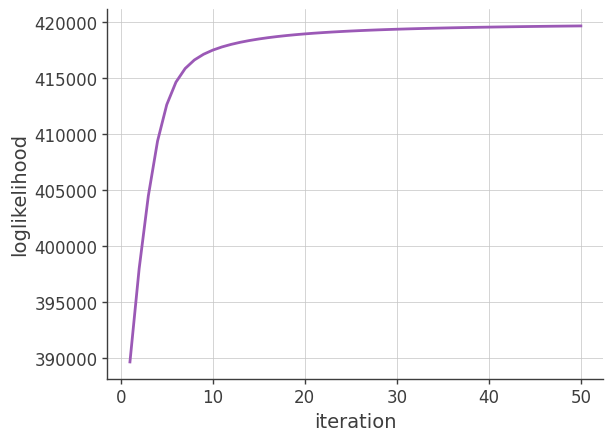

In [61]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['loglikelihood'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("loglikelihood")
plt.show()

## Alpha (the factor used for the acceleration)

Plotting $\alpha$ vs the number of iterations. $\alpha$ is a parameter to accelerate the EM algorithm (see the beginning of Section 4). If it is too large, reconstructed images may have artifacts.

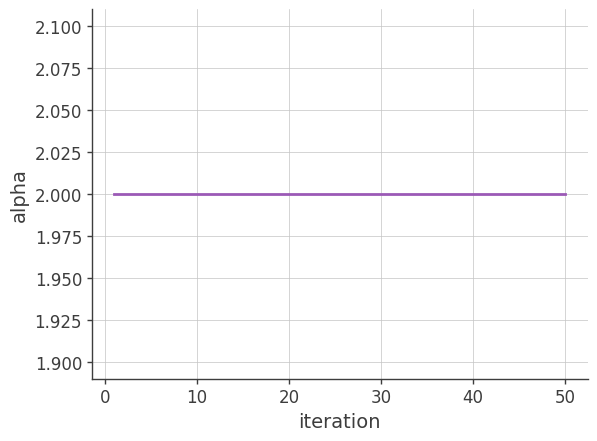

In [62]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['alpha'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("alpha")
plt.show()

## Background normalization

Plotting the background nomalization factor vs the number of iterations. If the backgroud model is accurate and the image is reconstructed perfectly, this factor should be close to 1.

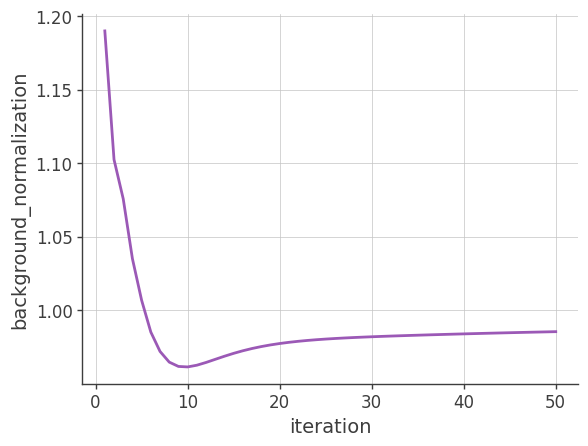

In [63]:
x, y = [], []

for result in image_deconvolution.results:
    x.append(result['iteration'])
    y.append(result['background_normalization']['albedo'])
    
plt.plot(x, y)
plt.grid()
plt.xlabel("iteration")
plt.ylabel("background_normalization")
plt.show()

## The reconstructed images

In [64]:
def plot_reconstructed_image(result, source_position = None): # source_position should be (l,b) in degrees
    iteration = result['iteration']
    image = result['model']

    for energy_index in range(image.axes['Ei'].nbins):
        map_healpxmap = HealpixMap(data = image[:,energy_index], unit = image.unit)

        _, ax = map_healpxmap.plot('mollview')        
        
        _.colorbar.set_label(str(image.unit))
        
        if source_position is not None:
            ax.scatter(source_position[0]*u.deg, source_position[1]*u.deg, transform=ax.get_transform('world'), color = 'red')

        plt.title(label = f"iteration = {iteration}, energy_index = {energy_index} ({image.axes['Ei'].bounds[energy_index][0]}-{image.axes['Ei'].bounds[energy_index][1]})")

Plotting the reconstructed images in all of the energy bands at the 50th iteration

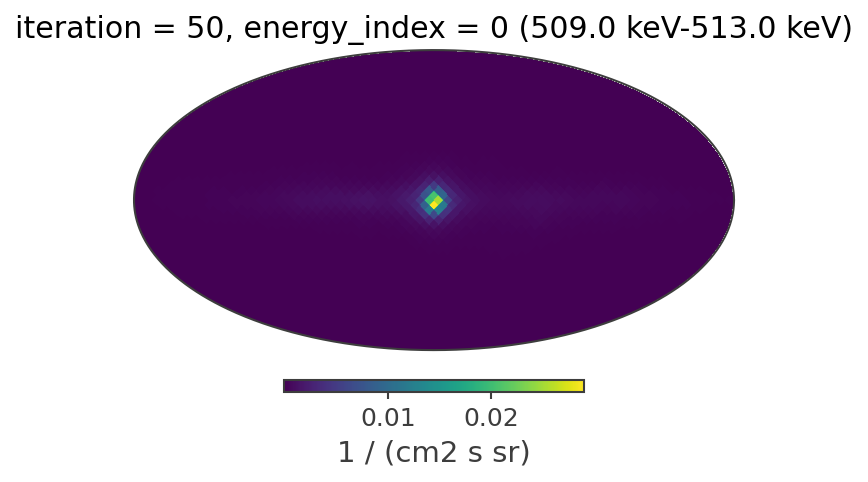

In [65]:
iteration = 49

plot_reconstructed_image(image_deconvolution.results[iteration])

An example to plot the image in the log scale

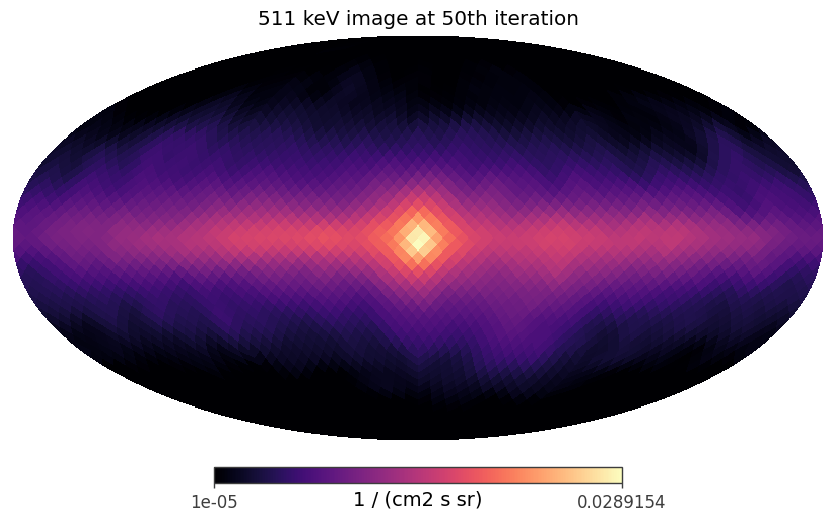

In [66]:
iteration_idx = 49

result = image_deconvolution.results[iteration_idx]

iteration = result['iteration']
image = result['model']

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()

**Note: when you use a smoothing filter, you may see arfacts like many rings around the galactic center as seen in the next image. This is likely caused by the calculation errors of hp.smoothing and the high contrast of the 511 keV image. It is expected that these artifacts will be mitigated by using finer pixel resolution.**

For reference, the parameters used for the image below is:
```
algorithm: RL
parameter:
  acceleration: true
  alpha_max: 2.0
  background_normalization_optimization: true
  background_normalization_range:
    albedo:
    - 0.01
    - 10.0
  iteration_max: 50
  response_weighting: false
  response_weighting_index: 0.5
  save_results: false
  save_results_directory: ./results
  smoothing: true
  smoothing_FWHM:
    unit: deg
    value: 2.0
```

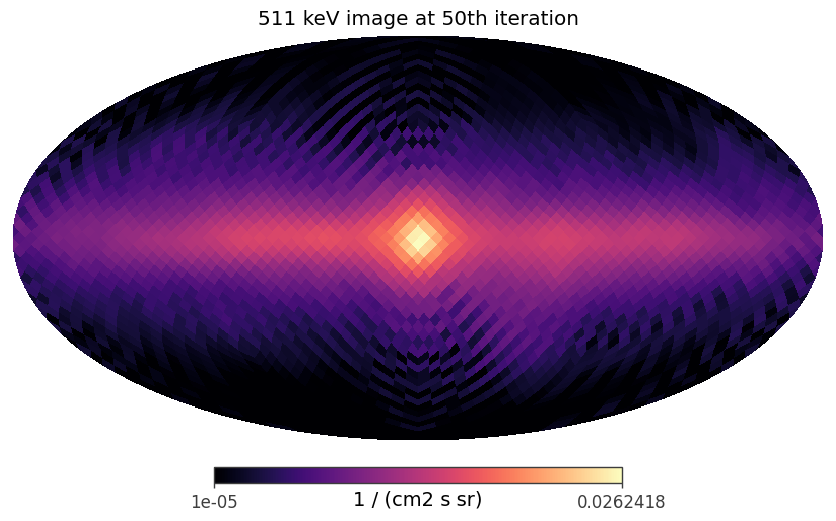

In [57]:
iteration_idx = 49

result = image_deconvolution.results[iteration_idx]

iteration = result['iteration']
image = result['model']

data = image[:,0]
data[data <= 0 * data.unit] = 1e-12 * data.unit

hp.mollview(data, min = 1e-5, norm ='log', unit = str(data.unit), title = f'511 keV image at {iteration}th iteration', cmap = 'magma')

plt.show()